<a href="https://colab.research.google.com/github/TZS3138/your-repo/blob/main/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec 30 13:38:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install matplotlib pandas numpy Pillow

Looking in indexes: https://download.pytorch.org/whl/cu124


**Part 1:**

1. Data Exploration & Analysis

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import random
import os
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [ ]:
# Oxford 102 Flowers Dataset
from torchvision.datasets import Flowers102

# Download and Load Datasets
transform = transforms.ToTensor()
flowers_train = Flowers102(root="./data", split="train", download=True, transform=transform)
flowers_val = Flowers102(root="./data", split="val", download=True, transform=transform)
flowers_test = Flowers102(root="./data", split="test", download=True, transform=transform)

print(f"Train samples: {len(flowers_train)}")
print(f"Validation samples: {len(flowers_val)}")
print(f"Test samples: {len(flowers_test)}")
print(f"Total classes: {len(flowers_train.classes)}")

100%|██████████| 345M/345M [00:13<00:00, 26.2MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.44MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 36.0MB/s]


Train samples: 1020
Validation samples: 1020
Test samples: 6149
Total classes: 102


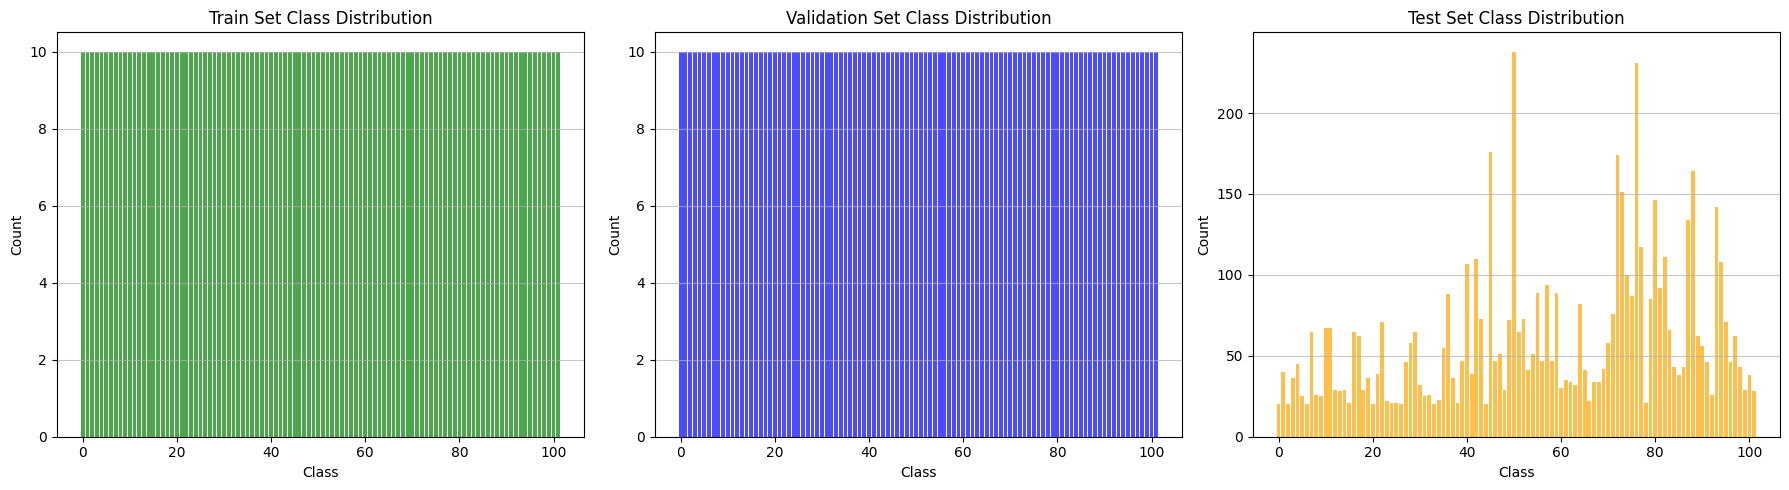

In [ ]:
# Class Distribution Visualization - Bar Graph
def get_counts(dataset):
    return Counter(dataset._labels)

train_counts = get_counts(flowers_train)
val_counts = get_counts(flowers_val)
test_counts = get_counts(flowers_test)

plt.figure(figsize=(18, 5))

datasets_info = [
    (train_counts, "Train Set Class Distribution", "green"),
    (val_counts, "Validation Set Class Distribution", "blue"),
    (test_counts, "Test Set Class Distribution", "orange")
]

for i, (counts, title, color) in enumerate(datasets_info, 1):
    plt.subplot(1, 3, i)
    plt.bar(counts.keys(), counts.values(), alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()

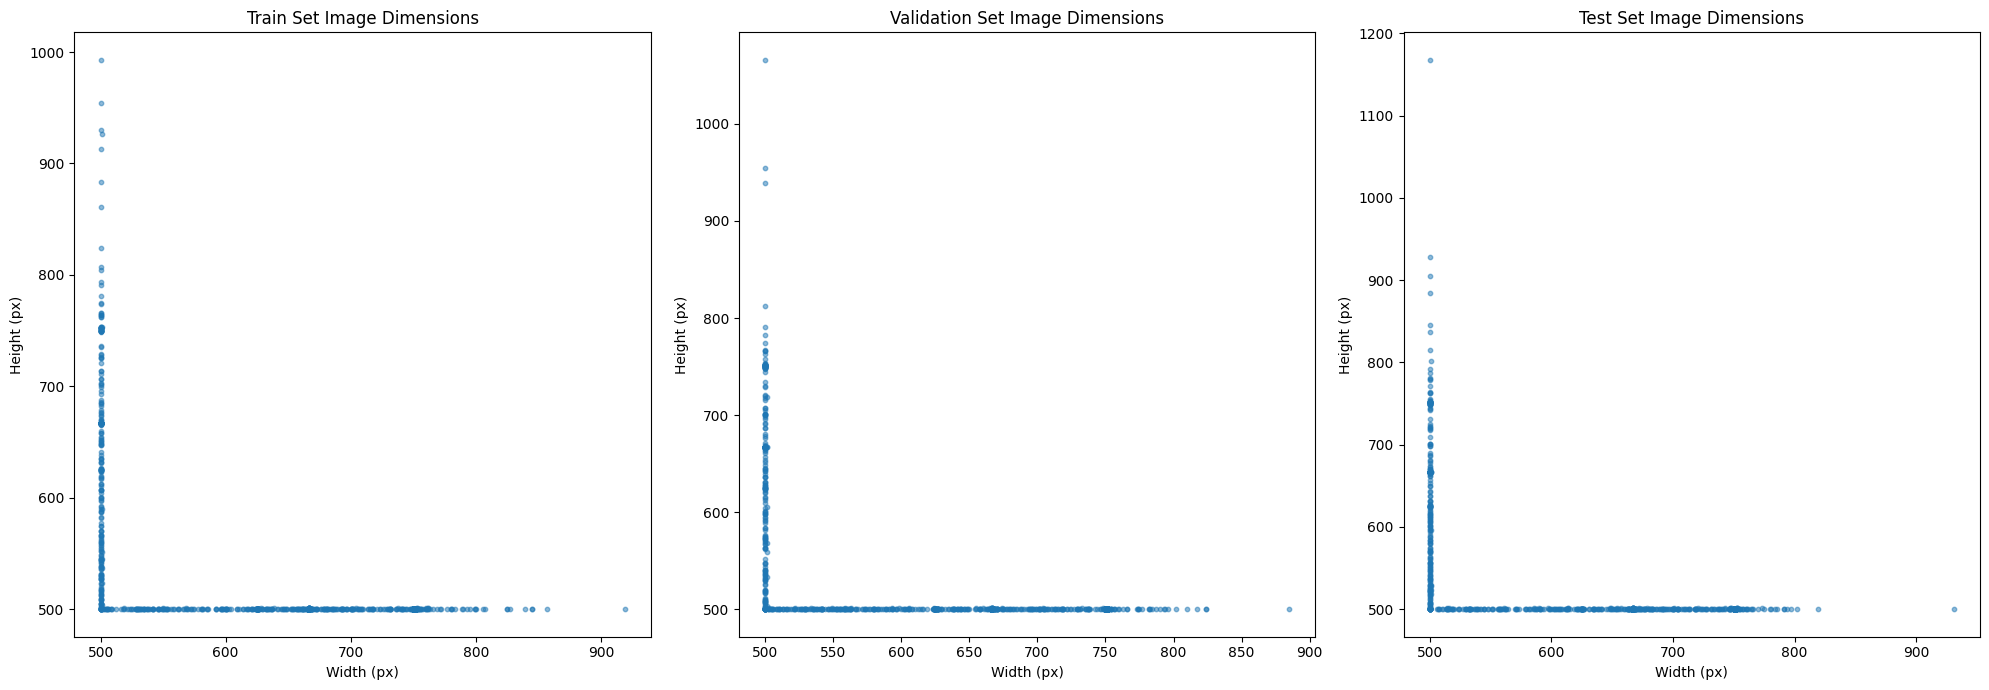

In [ ]:
# Image Dimensions Visualisation - Scatter Plot
def get_image_dimensions(dataset, sample_size=1000): # 1000 is used as it nearly covered the entire training set
    sizes = []
    indices = random.sample(range(len(dataset)), min(sample_size, len(dataset)))
    for i in indices:
        img, _ = dataset[i]
        h, w = img.shape[1], img.shape[2]
        sizes.append((w, h))
    return pd.DataFrame(sizes, columns=["width", "height"])

df_train = get_image_dimensions(flowers_train)
df_val = get_image_dimensions(flowers_val)
df_test = get_image_dimensions(flowers_test)

plt.figure(figsize=(20, 7))

dim_data = [(df_train, "Train Set"), (df_val, "Validation Set"), (df_test, "Test Set")]

for i, (df, name) in enumerate(dim_data, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df["width"], df["height"], alpha=0.5, s=10)
    plt.title(f"{name} Image Dimensions")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")

plt.tight_layout()
plt.show()

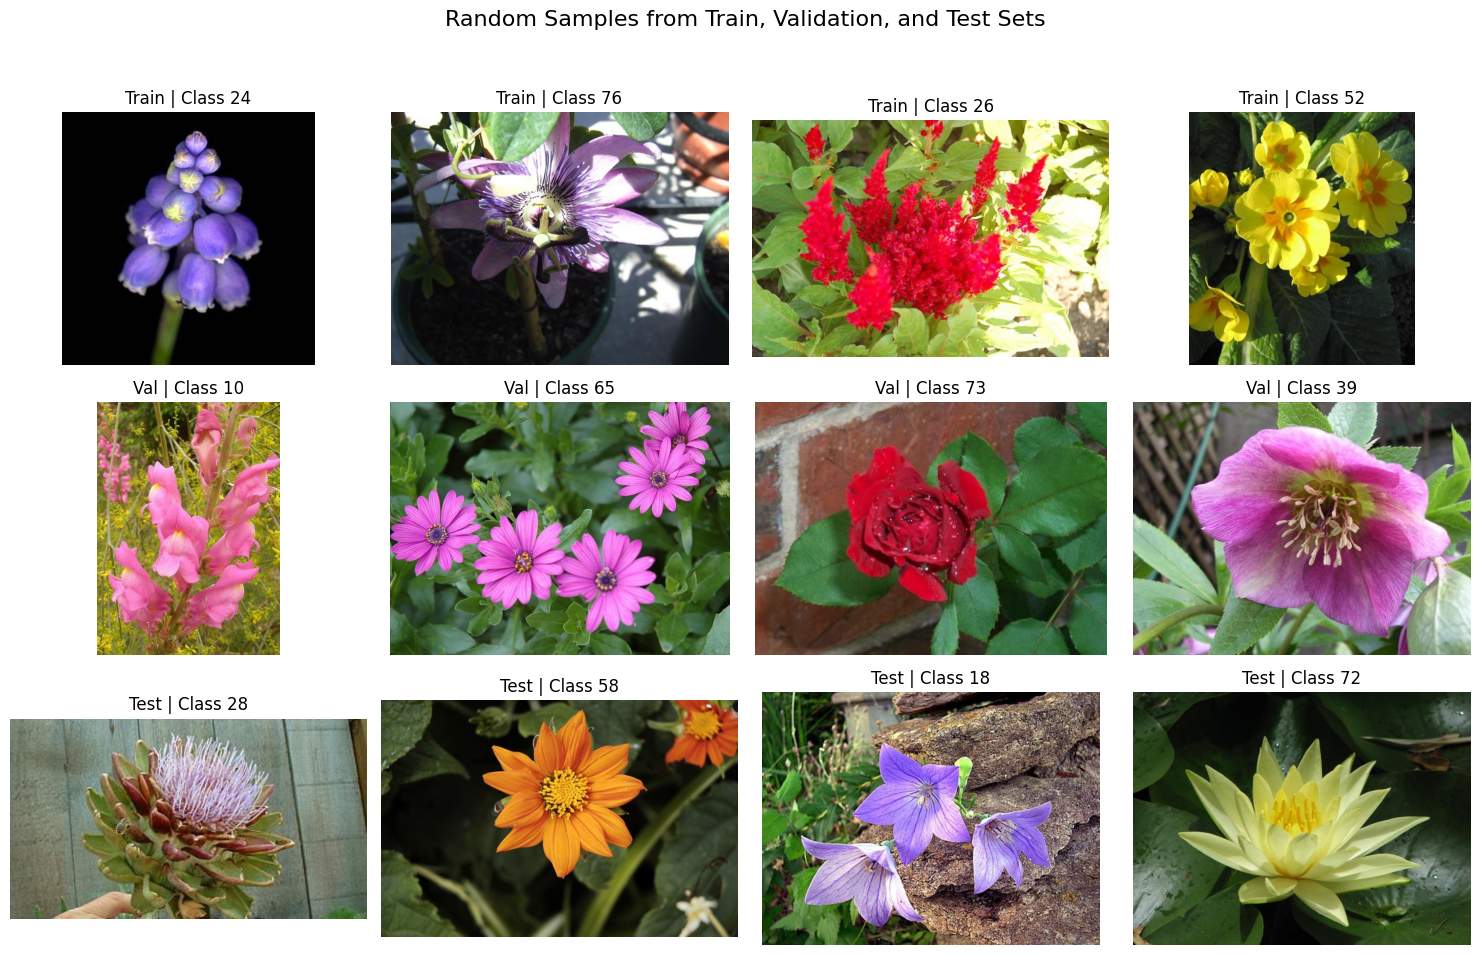

In [ ]:
# Sample Images Visualisation
def plot_samples(dataset, num_samples=4):
    indices = random.sample(range(len(dataset)), num_samples)
    imgs = []
    labels = []
    for i in indices:
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        imgs.append(img)
        labels.append(label)
    return imgs, labels

# Prepare Data (4x Train, 4x Validation, 4x Test)
train_imgs, train_labs = plot_samples(flowers_train)
val_imgs, val_labs = plot_samples(flowers_val)
test_imgs, test_labs = plot_samples(flowers_test)

all_imgs = train_imgs + val_imgs + test_imgs
all_labels = train_labs + val_labs + test_labs
titles = ["Train"]*4 + ["Val"]*4 + ["Test"]*4

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(all_imgs[i])
    axes[i].set_title(f"{titles[i]} | Class {all_labels[i]}")
    axes[i].axis("off")

plt.suptitle("Random Samples from Train, Validation, and Test Sets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

For the training and validation sets, classes are perfectly balanced with exactly 10 images per class. However, the split ratio between training, validation, and test sets is not common, where the test set is significantly larger than the training set and validation set, forming roughly 12.5% Train, 12.5% Val and 75% Test.

Furthermore, the presence of both landscape and portrait orientations suggests that the model must be invariant to aspect ratio changes. The images are not uniform in size, with dimensions ranging roughly from 500px to 1100px. Resizing and normalization step is required to ensure all input have the same dimensions.

From the sample images visualisation, the sample images reveals high-resolution quality with the flower or flowers being large and well-centered in most frames.

2. Data Pipeline

In [ ]:
# Data Loading Pipeline
from torch.utils.data import DataLoader

# Train Augmentations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation & Test Augmentations
# Only have resize, crop, and normalization to standardise the input and imitate the real world
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Re-load Datasets with Specific Transforms
train_set = datasets.Flowers102(root="./data", split="train", transform=train_transforms)
val_set = datasets.Flowers102(root="./data", split="val", transform=val_test_transforms)
test_set = datasets.Flowers102(root="./data", split="test", transform=val_test_transforms)

# 3. Implement DataLoaders
# Set shuffle=True for training to ensure the model doesn't learn the order of classes.
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"DataLoaders initialized.")

DataLoaders initialized.


ResNet architectures are traditionally trained on 224x224 images. This resolution preserves the spatial features the pre-trained weights expect. The mean and std used are the standard statistics of the ImageNet dataset which is critical for transfer learning to work effectively. The built-in split of Flowers102 is used. This is because it is already stratified with 10 samples per class for Training.